<a href="https://colab.research.google.com/github/ZiggerZZ/taxitime/blob/master/Training_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from math import sqrt

# Training

In [0]:
# read preprocessed data 

df = pd.read_csv('https://raw.githubusercontent.com/ZiggerZZ/taxitime/master/data/complete_data.csv')
df.drop(['scheduled_time_off','estimated_inblock_time'],axis=1,inplace=True) # we can not use these columns

## Baseline

In [0]:
df['moving_average'] = df.t_minutes.rolling(window=50000).mean() # 50000 rows correspond to approximately two months

df_result = df.dropna(subset=['moving_average'])[['t_minutes','moving_average']]
rmse_moving_average = sqrt(mean_squared_error(df_result['t_minutes'], df_result['moving_average']))
print(rmse_moving_average)

4.657023285082811


## Our models

### Utils

In [0]:
def train_test(df, model_columns, categorical_columns, split = 0.8):
  X = pd.get_dummies(df[model_columns], categorical_columns) # convert categoricals to numericals and keep numericals

  num_train = int(split*X.shape[0]) # split %

  X_train = X.iloc[:num_train].drop('t_minutes', axis = 1)
  y_train = X.iloc[:num_train].t_minutes
  X_test = X.iloc[num_train:].drop('t_minutes', axis = 1)
  y_test = X.iloc[num_train:].t_minutes  
  return X, X_train, y_train, X_test, y_test

def rmse_model(model,X_train,y_train,X_test,y_test):
  model.fit(X_train,y_train)
  rmse_train = sqrt(mean_squared_error(y_train, model.predict(X_train)))
  rmse_test = sqrt(mean_squared_error(y_test, model.predict(X_test)))
  return rmse_train, rmse_test

### All features

In [0]:
air_columns = ['carrier', 'runway']
time_columns = ['week_of_year', 'day_of_week', 'minutes_of_day', 'minute_of_week', 'land_to_off', 't_minutes']
traffic_columns = ['traffic_metric']
size_columns = ['Approach Speed\n(Vref)', 'MTOW', 'Max Ramp\nMax Taxi', 'dim_proxy'] # []
weather_columns = ['average_wind_speed', 'precipitation', 'average_temperature', 'direction_of_fastest_2_minute_wind', 'direction_of_fastest_5_second_wind', 'fastest_2_minute_wind_speed', 'fog,_ice_fog,_or_freezing_fog_(incl_heavy_fog)', 'heavy_fog_or_heaving_freezing_fog', 'thunder', 'smoke_or_haze']

model_columns = air_columns + time_columns + traffic_columns + size_columns + weather_columns
categorical_columns = ['carrier', 'runway', 'day_of_week']

X, X_train, y_train, X_test, y_test = train_test(df, model_columns, categorical_columns)

In [0]:
len(model_columns)

23

First we train on all features for all three models to get benchmark RMSEs  
We use the feature importance generated from the gradient boosting model to find the best 10 upon which we will create feature sets.




In [0]:
for model in [('RF',RandomForestRegressor()), ('Linear',LinearRegression()), ('GB',GradientBoostingRegressor())]:
  print(model[0])
  rmse_score = rmse_model(model[1], X_train_feats, y_train_feats, X_test_feats, y_test_feats)
  print(rmse_score)

RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(1.7586042245077211, 4.9460890628319385)
Linear
(4.227043214427869, 4.274242023349024)
GB
(3.9073240693862963, 4.2138924843618515)


(3.9006633120610106, 4.192176484648863)


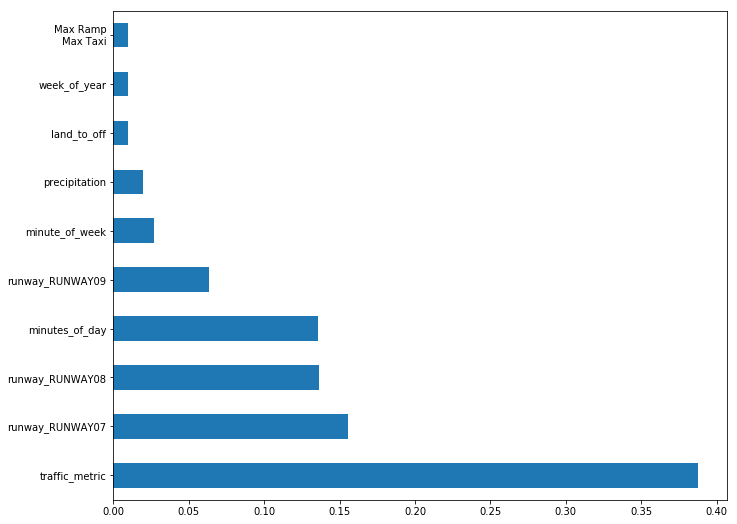

In [0]:
model = GradientBoostingRegressor()
print(rmse_model(model, X_train, y_train, X_test, y_test))
feat_importances = pd.Series(model.feature_importances_, index=X.drop('t_minutes',axis=1).columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(11,9))

### Important features

As we can see from the plot above, not all features are important.
We will retrain our model with increasing feature sets, starting with the most important feature **traffic metric** and adding the next important features one by one.


In [0]:
 results = {i: [] for i in range(1,11)}

feats = feat_importances.nlargest(10).keys()
for i in range(1, len(feats) + 1):
  print(i)
  first_i_imp_feats = feats[0:i]
  X_feats, X_train_feats, y_train_feats, X_test_feats, y_test_feats = \
  X[first_i_imp_feats], X_train[first_i_imp_feats], y_train, X_test[first_i_imp_feats], y_test
  print(list(first_i_imp_feats))
  
  for model in [('RF',RandomForestRegressor()), ('Linear',LinearRegression()), ('GB',GradientBoostingRegressor())]:
    print(model[0])
    rmse_score = rmse_model(model[1], X_train_feats, y_train_feats, X_test_feats, y_test_feats)
    print(rmse_score)
    results[i].append(rmse_score[0])
    results[i].append(rmse_score[1])
    
  print('--------')

1
['traffic_metric']
	 RF
(4.355922436118786, 4.517353922109242)
	 Linear
(4.48533340890986, 4.525536548655984)
	 GB


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(4.35298136803555, 4.51741949817507)
--------
2
['traffic_metric', 'runway_RUNWAY07']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(4.237277485613389, 4.427845703958297)
	 Linear
(4.393763640932437, 4.433636630816845)
	 GB
(4.241731049685323, 4.426817004222909)
--------
3
['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(4.110872719506539, 4.301551918863784)
	 Linear
(4.282977666761858, 4.31265811460228)
	 GB
(4.11935764478323, 4.30026206586646)
--------
4
['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08', 'minutes_of_day']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(3.399344814007304, 4.80463664713814)
	 Linear
(4.262542026925698, 4.288432153384788)
	 GB
(3.9924481939157426, 4.248627680871162)
--------
5
['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08', 'minutes_of_day', 'runway_RUNWAY09']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(3.199761659444282, 4.876014335394993)
	 Linear
(4.240952704850273, 4.264354695346473)
	 GB
(3.965704635945305, 4.217691297660148)
--------
6
['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08', 'minutes_of_day', 'runway_RUNWAY09', 'minute_of_week']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(2.3692658197328567, 4.849026251058254)
	 Linear
(4.2409291201970705, 4.264830486673306)
	 GB
(3.961980509539437, 4.217828748144534)
--------
7
['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08', 'minutes_of_day', 'runway_RUNWAY09', 'minute_of_week', 'precipitation']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(2.067061922995632, 4.734401087665008)
	 Linear
(4.2352496191735876, 4.257018525880936)
	 GB
(3.947615852652035, 4.216822508530218)
--------
8
['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08', 'minutes_of_day', 'runway_RUNWAY09', 'minute_of_week', 'precipitation', 'land_to_off']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(1.8169493707170876, 4.674403658376722)
	 Linear
(4.233705694689888, 4.259286665266238)
	 GB
(3.9408208153278976, 4.2079434578854205)
--------
9
['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08', 'minutes_of_day', 'runway_RUNWAY09', 'minute_of_week', 'precipitation', 'land_to_off', 'week_of_year']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(1.796873157153402, 5.08104960981001)
	 Linear
(4.233174323260978, 4.271920111050988)
	 GB
(3.937688446781077, 4.236125109383013)
--------
10
['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08', 'minutes_of_day', 'runway_RUNWAY09', 'minute_of_week', 'precipitation', 'land_to_off', 'week_of_year', 'Max Ramp\nMax Taxi']
	 RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(1.7861242388599474, 4.911313852474273)
	 Linear
(4.227043214427869, 4.274242023349024)
	 GB
(3.9073240693862963, 4.2138924843618515)
--------


Below are our results, on the y axis is the number of features. The Columns represent the train and test RMSEs:  
0: Random Forest Train RMSE  
1: Random Forest Test RMSE  
2: Linear Regression Train RMSE  
3: Linear Regression Test RMSE  
4: Gradient Boosting Regression Train RMSE  
5: Gradient Boosting Regression Test RMSE  

In [0]:
pd.set_option("display.precision", 2)
pd.DataFrame(results).T

,0,1,2,3,4,5
1,4.36,4.52,4.49,4.53,4.35,4.52
2,4.24,4.43,4.39,4.43,4.24,4.43
3,4.11,4.30,4.28,4.31,4.12,4.30
4,3.40,4.80,4.26,4.29,3.99,4.25
5,3.20,4.88,4.24,4.26,3.97,4.22
6,2.37,4.85,4.24,4.26,3.96,4.22
7,2.07,4.73,4.24,4.26,3.95,4.22
8,1.82,4.67,4.23,4.26,3.94,4.21
9,1.80,5.08,4.23,4.27,3.94,4.24
10,1.79,4.91,4.23,4.27,3.91,4.21


### Residuals

In [0]:
model = GradientBoostingRegressor()
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
train_errors = (y_train - y_train_pred)
mse_train = mean_squared_error(y_train, model.predict(X_train))
y_test_pred = model.predict(X_test)
test_errors = (y_test - y_test_pred)
mse_test = mean_squared_error(y_test, model.predict(X_test))

In [0]:
from matplotlib.pyplot import hist
%matplotlib inline

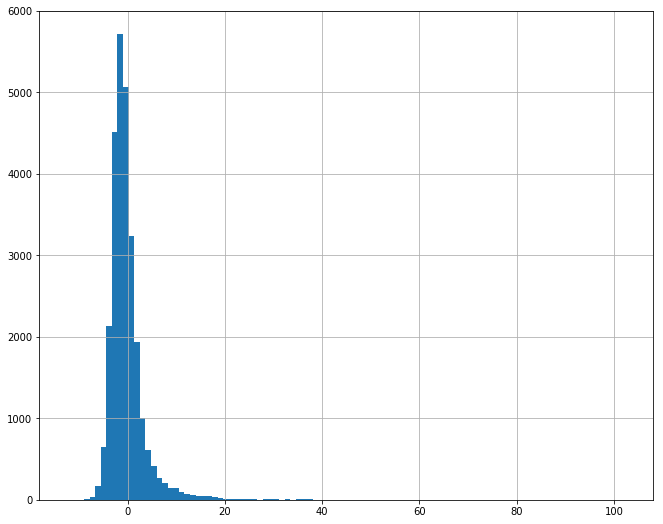

In [0]:
test_errors.hist(bins=100, figsize=(11,9))

### Test data

In [0]:
df_test = pd.read_csv('https://raw.githubusercontent.com/ZiggerZZ/taxitime/master/data/test_complete_data.csv')
df_test.drop(['scheduled_time_off','estimated_inblock_time'],axis=1,inplace=True) # we can not use these columns

In [0]:
features5 = ['traffic_metric', 'runway_RUNWAY07', 'runway_RUNWAY08', 'minutes_of_day', 'runway_RUNWAY09', 't_minutes']

X = pd.get_dummies(df[model_columns], categorical_columns) # convert categoricals to numericals and keep numericals
X_test_eleven = pd.get_dummies(df_test[model_columns], categorical_columns)


X_train = X[features5].drop('t_minutes', axis = 1)
y_train = X.t_minutes
X_test = X_test_eleven[features5].drop('t_minutes', axis = 1)
y_test = X_test_eleven.t_minutes  

**Test data RMSE**  

Run on the best model Gradient Boosting with 5 features


In [0]:
model = GradientBoostingRegressor()
rmse_score = rmse_model(model, X_train, y_train, X_test, y_test)
print(rmse_score)

(4.014211924154692, 4.501806963662729)
